In [ ]:
#|default_exp callback.cutmixup

# CutMixUp
> fast.ai callbacks to add a combination of CutMix & MixUp, or CutMix, MixUp, & Augmentation.

In [ ]:
#|export
from __future__ import annotations

from torch.distributions.beta import Beta

from fastcore.transform import Pipeline, Transform

from fastai.data.transforms import IntToFloatTensor, Normalize
from fastai.callback.mixup import reduce_loss
from fastai.layers import NoneReduce

from fastxtend.multiloss import MixHandlerX
from fastxtend.imports import *

In [ ]:
#|hide
from nbdev.showdoc import *

## MixUp -

In [ ]:
#|export
class MixUp(MixHandlerX):
    "Implementation of https://arxiv.org/abs/1710.09412"
    def __init__(self,
        alpha:float=.4 # Alpha & beta parametrization for `Beta` distribution
    ):
        super().__init__(alpha)

    def before_batch(self):
        "Blend xb and yb with another random item in a second batch (xb1,yb1) with `lam` weights"
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

## CutMix -

In [ ]:
#|export
class CutMix(MixHandlerX):
    "Implementation of https://arxiv.org/abs/1905.04899"
    def __init__(self, 
        alpha:float=1. # Alpha & beta parametrization for `Beta` distribution
    ): 
        super().__init__(alpha)

    def before_batch(self):
        bs, _, H, W = self.x.size()
        self.lam = self.distrib.sample((1,)).to(self.x.device)
        shuffle = torch.randperm(bs).to(self.x.device)
        xb1,self.yb1 = self.x[shuffle], tuple((self.y[shuffle],))
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam).to(self.x.device)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.x.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.x.device)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - torch.div(cut_w, 2, rounding_mode='floor'), 0, W)
        y1 = torch.clamp(cy - torch.div(cut_h, 2, rounding_mode='floor'), 0, H)
        x2 = torch.clamp(cx + torch.div(cut_w, 2, rounding_mode='floor'), 0, W)
        y2 = torch.clamp(cy + torch.div(cut_h, 2, rounding_mode='floor'), 0, H)
        return x1, y1, x2, y2

## CutMixUp -

In [ ]:
#|export
class CutMixUp(MixUp, CutMix):
    "Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899"
    run_valid = False
    def __init__(self, 
        mix_alpha:float=.4, # MixUp alpha & beta parametrization for `Beta` distribution
        cut_alpha:float=1., # CutMix alpha & beta parametrization for `Beta` distribution
        mixup_ratio:Number=1, # Ratio to apply `MixUp` relative to `CutMix`
        cutmix_ratio:Number=1 # Ratio to apply `CutMix` relative to `MixUp`
    ): 
        store_attr()
        MixUp.__init__(self, mix_alpha)
        CutMix.__init__(self, cut_alpha)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)

    def before_batch(self):
        if torch.rand(1) <= self.ratio: #mixup
            self.distrib = self.mix_distrib
            MixUp.before_batch(self)
        else:
            self.distrib = self.cut_distrib
            CutMix.before_batch(self)

## CutMixUpAugment -

In [ ]:
#|export
class CutMixUpAugment(MixUp, CutMix):
    """
    Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899 plus Augmentation.

    Pulls augmentations from `Dataloaders.train.after_batch`. These augmentations are not applied when performing `MixUp` & `CutMix`, the frequency is controlled by `augment_ratio`.

    Use `augment_finetune` to only apply dataloader augmentations at the end of training.
    
    `cutmixup_augs` are an optional separate set of augmentations to apply with `MixUp` and `CutMix`. Usually less intensive then the dataloader augmentations. 
    """
    run_valid = False
    def __init__(self, 
        mix_alpha:float=.4, # MixUp alpha & beta parametrization for `Beta` distribution
        cut_alpha:float=1., # CutMix alpha & beta parametrization for `Beta` distribution
        mixup_ratio:Number=1, # Ratio to apply `MixUp` relative to `CutMix` & augmentations
        cutmix_ratio:Number=1, # Ratio to apply `CutMix` relative to `MixUp` & augmentations
        augment_ratio:Number=1, # Ratio to apply augmentations relative to `MixUp` & `CutMix`
        augment_finetune:Number|None=None, # Number of epochs or pct of training to only apply augmentations
        cutmixup_augs:listified[Transform|Callable[...,Transform]]|None=None # Augmentations to apply before `MixUp` & `CutMix`. Should not have `Normalize`
    ): 
        store_attr()
        MixUp.__init__(self, mix_alpha)
        CutMix.__init__(self, cut_alpha)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.aug_cutmix_ratio = augment_ratio / (augment_ratio + cutmix_ratio + mixup_ratio)
        if self.aug_cutmix_ratio == 1: self.cut_mix_ratio = 0
        else: self.cut_mix_ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)
        self._docutmixaug = cutmixup_augs is not None

    def before_fit(self):
        super().before_fit()
        if self.augment_finetune is None: self.augment_finetune = (self.learn.n_epoch + 1)/self.learn.n_epoch
        elif self.augment_finetune >= 1: self.augment_finetune = self.augment_finetune/self.learn.n_epoch
        else: self.augment_finetune = self.augment_finetune

        self._inttofloat_pipe = Pipeline([])
        self._norm_pipe = Pipeline([])
        self._cutmixaugs_pipe = Pipeline(self.cutmixup_augs) if self._docutmixaug else Pipeline([])
        
        # first copy transforms
        self._orig_pipe = self.dls.train.after_batch
        self._orig_pipe.split_idx = 0 # need to manually set split_idx for training augmentations to run
        
        # loop through existing transforms looking for IntToFloatTensor and Normalize
        for i in range(len(self.dls.train.after_batch.fs)):
            if isinstance(self.dls.train.after_batch[i], IntToFloatTensor):
                self._inttofloat_pipe = Pipeline([self.dls.train.after_batch[i]])
            elif isinstance(self.dls.train.after_batch[i], Normalize):
                self._norm_pipe = Pipeline([self.dls.train.after_batch[i]])

        # set existing transforms to an empty Pipeline
        self.dls.train.after_batch = Pipeline([])

    def before_batch(self):
        if self.augment_finetune >= self.learn.pct_train and torch.rand(1) >= self.aug_cutmix_ratio: # augs or mixup/cutmix
            self._doaugs = False
            self.learn.xb = self._inttofloat_pipe(self.xb) # apply inttofloat first
            if self._docutmixaug:
                self.learn.xb = self._cutmixaugs_pipe(self.xb)
            if self.cut_mix_ratio > 0 and torch.rand(1) <= self.cut_mix_ratio: # mixup or cutmix
                self.distrib = self.mix_distrib
                MixUp.before_batch(self)
            else:
                self.distrib = self.cut_distrib
                CutMix.before_batch(self)
            self.learn.xb = self._norm_pipe(self.xb) # now normalize
        else:
            self._doaugs = True
            self.learn.xb = self._orig_pipe(self.xb) # original transforms

    def after_fit(self):
        self.dls.train.after_batch = self._orig_pipe

    def after_cancel_fit(self):
        self.after_fit()
        MixUp.after_cancel_fit(self)

    def solo_lf(self, pred, *yb):
        "`norm_lf` applies the original loss function on both outputs based on `self.lam` if applicable"
        if not self.training or self._doaugs: 
            return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def multi_lf(self, pred, *yb):
        "`norm_lf` applies the original loss function on both outputs based on `self.lam` if applicable"
        if not self.training or self._doaugs:
            return self.learn.loss_func_mixup(pred, *yb)
        else:
            return self.learn.loss_func_mixup.forward_mixup(pred, *self.yb1, *yb, self.lam)

## Testing

I will use the testing method from fast.ai's [19_callback.mixup.ipynb](https://github.com/fastai/fastai/blob/master/nbs/19_callback.mixup.ipynb)

In [ ]:
#|hide
#|slow
import matplotlib.pyplot as plt
from fastai.callback.training import ProgressCallback
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.learner import Learner, Recorder
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.augment import Resize, aug_transforms, Hue, Saturation
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders
from fastxtend.test_utils import *

# hide imported deprecation warnings from PyTorch 1.10
import warnings
warnings.filterwarnings('ignore')

def test_cutmixup(cb, more_augs=False):
    norm = [Normalize.from_stats(*imagenet_stats)]
    augs = [*aug_transforms(max_rotate=45, max_warp=0.3, max_lighting=0.3, xtra_tfms=[Hue(), Saturation()])]
    
    path = untar_data(URLs.PETS)
    pat        = r'([^/]+)_\d+.*$'
    fnames     = get_image_files(path/'images')
    item_tfms  = [Resize(128, method='crop')]
    batch_tfms = norm+augs if more_augs else norm
    dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=16, item_tfms=item_tfms, 
                                        batch_tfms=batch_tfms)

    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cb) as learn:
        learn.remove_cbs([Recorder, ProgressCallback])
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_train')
        learn('before_batch')
        learn('after_fit')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cb.x, cb.y), ctxs=axs.flatten())

## Test CutMix

First test CutMix

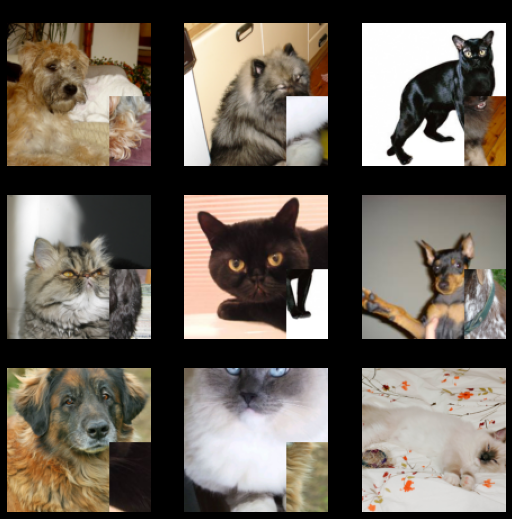

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUp(cutmix_ratio=1, mixup_ratio=0)
    test_cutmixup(cutmix)

Then MixUp

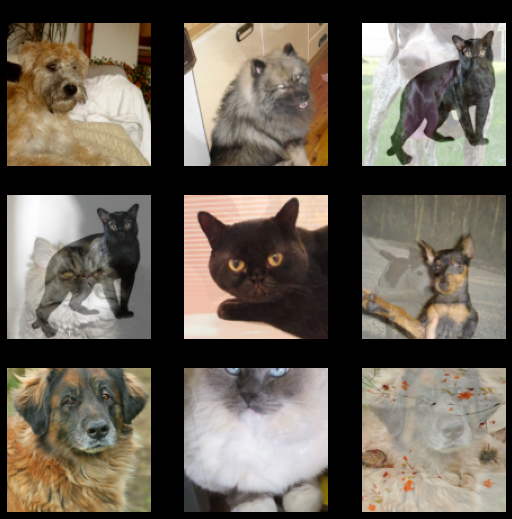

In [ ]:
#|slow
with less_random():
    mixup = CutMixUp(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1)
    test_cutmixup(mixup)

## Test CutMixAugment

First test CutMix

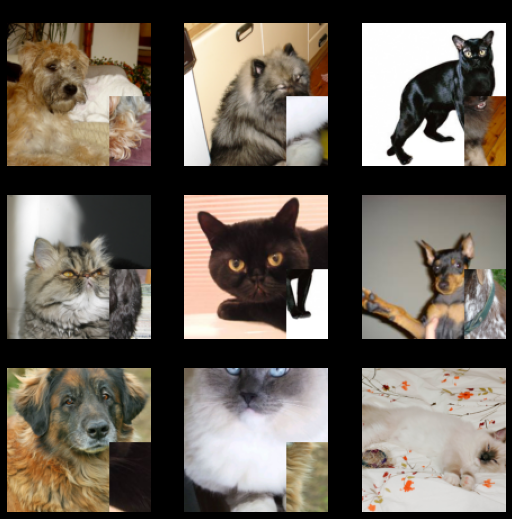

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUpAugment(cutmix_ratio=1, mixup_ratio=0, augment_ratio=0)
    test_cutmixup(cutmix, True)

CutMix with weak augmentations

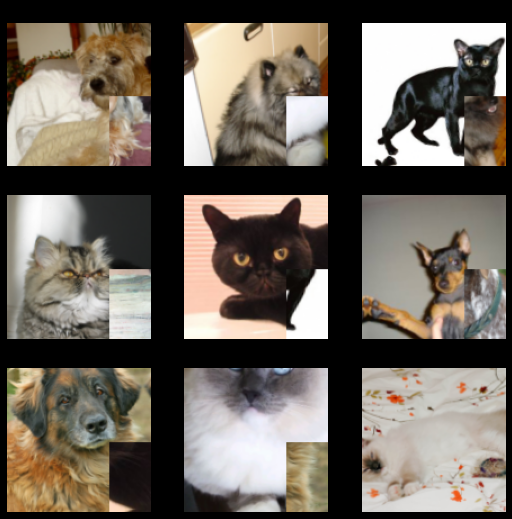

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUpAugment(cutmix_ratio=1, mixup_ratio=0, augment_ratio=0,
                             cutmixup_augs=aug_transforms(max_warp=0.1, max_lighting=0.1))
    test_cutmixup(cutmix, True)

Then MixUp

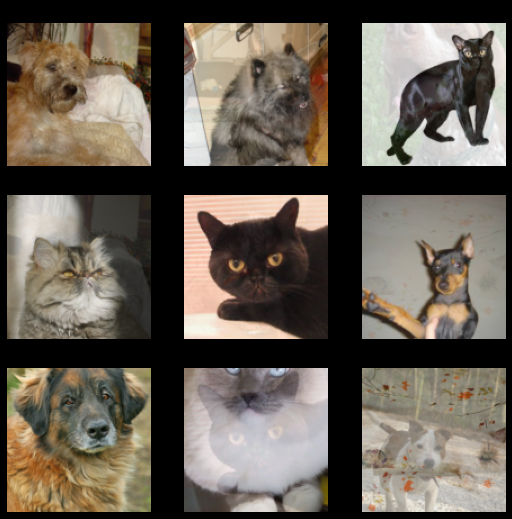

In [ ]:
#|slow
with less_random():
    mixup = CutMixUpAugment(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1, augment_ratio=0)
    test_cutmixup(mixup, True)

MixUp with weak augmentations

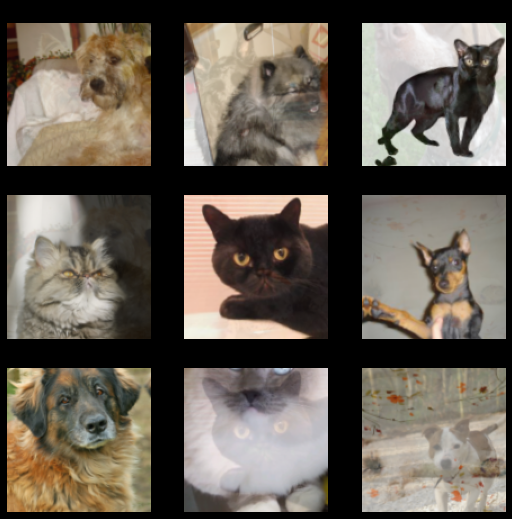

In [ ]:
#|slow
with less_random():
    mixup = CutMixUpAugment(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1, augment_ratio=0,
                            cutmixup_augs=aug_transforms(max_warp=0.1, max_lighting=0.1))
    test_cutmixup(mixup, True)

Finally just the strong augmentations

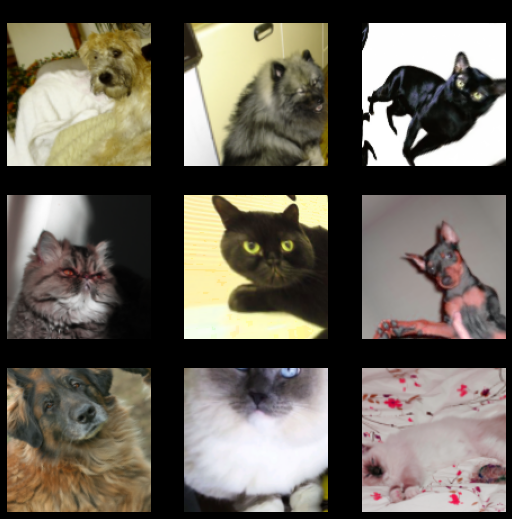

In [ ]:
#|slow
with less_random():
    augment = CutMixUpAugment(cutmix_ratio=0, mixup_ratio=0, augment_ratio=1)
    test_cutmixup(augment, True)